<a href="https://colab.research.google.com/github/rakshitgupta22/ToxicCommentClassification/blob/main/Toxic_Comment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting Dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_union
import pickle

In [ ]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1b0BcOqd8kv_6qhtKdBEeVPt7XjoqSego'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv') 

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Data Visualization


15294 toxic comments. (9.58% of all data.)
- 1595 or 10.43% were also severe_toxic.
- 7926 or 51.82% were also obscene.
- 449 or 2.94% were also threat.
- 7344 or 48.02% were also insult.
- 1302 or 8.51% were also identity_hate.

1595 severe_toxic comments. (1.00% of all data.)
- 1595 or 100.00% were also toxic.
- 1517 or 95.11% were also obscene.
- 112 or 7.02% were also threat.
- 1371 or 85.96% were also insult.
- 313 or 19.62% were also identity_hate.

8449 obscene comments. (5.29% of all data.)
- 7926 or 93.81% were also toxic.
- 1517 or 17.95% were also severe_toxic.
- 301 or 3.56% were also threat.
- 6155 or 72.85% were also insult.
- 1032 or 12.21% were also identity_hate.

478 threat comments. (0.30% of all data.)
- 449 or 93.93% were also toxic.
- 112 or 23.43% were also severe_toxic.
- 301 or 62.97% were also obscene.
- 307 or 64.23% were also insult.
- 98 or 20.50% were also identity_hate.

7877 insult comments. (4.94% of all data.)
- 7344 or 93.23% were also toxic.
- 1371 

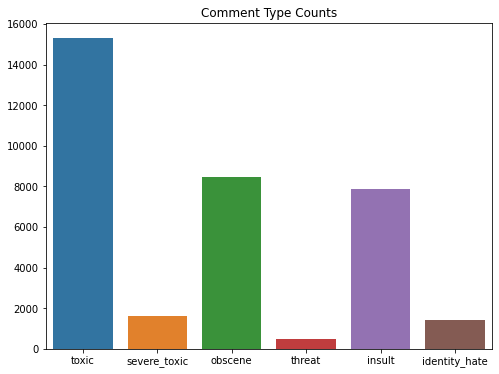

In [ ]:
targets = list(df.columns[2:])
df_targets = df[targets].copy()

count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts

totals = []
for key, value in count_dic.items():
    totals.append(value[0][1])
    print('\n%d %s comments. (%.2f%% of all data.)' % (value[0][1], key, (value[0][1]/len(df))*100))
    for cnt in value[1:]:
        print('- %d or %.2f%% were also %s.' % (cnt[1], (cnt[1]/value[0][1])*100, cnt[0]))

plt.figure('Comment Type Counts', figsize=[8,6])
plt.title('Comment Type Counts')
sns.barplot(x=list(count_dic.keys()), y=totals)
plt.show()

### Pre-Processing

#### Feature Engineering

In [ ]:
def feature_engineering(df, sparse=0): 
    
    # Comment length
    df['length'] = df.comment_text.apply(lambda x: len(x))
    

    # Capitalization percentage
    def pct_caps(s):
        return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
    df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))

    # Mean Word length 
    def word_length(s):
        s = s.split(' ')
        return np.mean([len(w) for w in s if w.isalpha()])
    df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

    # Average number of exclamation points 
    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    # Average number of question marks 
    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))

    # Strip IP Addresses
    ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
    def strip_ip(s, ip):
        try:
            found = ip.search(s)
            return s.replace(found.group(), ' ')
        except:
            return s

    df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))
    
    return df

def merge_features(comment_text, data, engineered_features):
    new_features = sparse.csr_matrix(data[engineered_features].values)
    if np.isnan(new_features.data).any():
        new_features.data = np.nan_to_num(new_features.data)
    return sparse.hstack([comment_text, new_features])

In [ ]:
df = feature_engineering(df)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,caps,word_length,exclamation,question
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,0.083333,4.500000,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,0.108108,6.250000,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,0.021390,4.638889,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,0.022587,4.212766,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,0.039216,4.125000,0,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['length', 'caps', 'word_length', 'question', 'exclamation']] = scaler.fit_transform(df[['length', 'caps', 'word_length', 'question', 'exclamation']])

with open('MinMaxScaler.pkl', 'wb') as file:
  pickle.dump(scaler, file)

In [ ]:
with open('MinMaxScaler.pkl', 'rb') as file:
  scaler = pickle.load(file)

df[['length', 'caps', 'word_length', 'question', 'exclamation']] = scaler.transform(df[['length', 'caps', 'word_length', 'question', 'exclamation']])

In [ ]:
print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data')
df.drop(list(df_targets.columns), inplace=True, axis=1)
df.drop('id', inplace=True, axis=1)
print(list(df.columns))
print(df.shape)

toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)
targets.append('any_label')
df_targets['any_label'] = toxic_rows.astype(int)

new_features = list(df.columns[1:])

Training labels:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(159571, 6)

Training data
['comment_text', 'length', 'caps', 'word_length', 'exclamation', 'question']
(159571, 6)


#### Vectorizing the Comments

Run only one of the 2 sections below

In [ ]:
#TF-IDF Vectorizor

comment_vector = TfidfVectorizer(max_features=25000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)

In [ ]:
with open('vectorizer.pkl', 'rb') as file:
  comment_vector = pickle.load(file)

In [ ]:
training_comments = comment_vector.transform(df.comment_text)

#### Splitting Datasets

In [ ]:
X = merge_features(training_comments, df, new_features)

In [ ]:
sparse.save_npz("trainmatrix.npz", X)

In [ ]:
downloaded = drive.CreateFile({'id':'1Td1nh_L8W3cRt0Y193hvg2qSNxGJA5iH'})
downloaded.GetContentFile('trainmatrix.npz') 

In [ ]:
X = sparse.load_npz("trainmatrix.npz")

In [ ]:
from sklearn.model_selection import train_test_split
#60% 20% 20% split
X_train_validate, X_test, y_train_validate, y_test,  = train_test_split(X, df_targets, test_size=0.2, random_state=0)
X_train, X_validate, y_train, y_validate,  = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state=0)

In [ ]:
X.shape

(159571, 25005)

In [ ]:
df_targets.shape

(159571, 7)

In [ ]:
print(X_train.shape,y_train.shape, 
      X_validate.shape, y_validate.shape,
      X_test.shape, y_test.shape)

(95742, 25005) (95742, 7) (31914, 25005) (31914, 7) (31915, 25005) (31915, 7)


### Helper Functions

#### Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.metrics import classification_report

def cross_validate(num_splits, X, Y, model):

  kf = StratifiedKFold(n_splits=num_splits, shuffle= True, random_state=0)
  labels = Y.columns
  label_scores = {}

  for label in labels:
    score_list = cross_val_score(clone(model), X, Y[label], scoring='f1', cv=kf)
    #print(label, ":", score_list)
    label_scores[str(label) + " avg f1 score"] = np.mean(score_list)
    
  return label_scores

#### Model Evaluation

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def model_evaluate(model, X_train, Y_train, X_test, Y_test, model_name):
  labels = Y_train.columns

  for label in labels:
    model.fit(X_train, Y_train[label])
    
    with open('%s_%s.pkl' %(model_name, label), 'wb') as file:
      pickle.dump(model, file)

    #Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    #F1-scores
    #Training Report
    report_train = classification_report(Y_train[label], train_pred)
    print("Training Classification Report for %s label:\n" % label,report_train)

    #Getting confusion matrix for Training Data
    cm_train = confusion_matrix(Y_train[label], train_pred, labels=model.classes_)

    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cm_train, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm_train.shape[0]):
        for j in range(cm_train.shape[1]):
            ax.text(x=j, y=i,s=cm_train[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.title("Training Confusion Matrix for %s" % label, fontsize=18)
    plt.show()

    #Testing Report
    report_test = classification_report(Y_test[label], test_pred)
    print("Testing Classification Report for %s label:\n" % label,report_test)

    #Getting confusion matrix for Validation Data
    cm_test = confusion_matrix(Y_test[label], test_pred, labels=model.classes_)

    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cm_test, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm_test.shape[0]):
        for j in range(cm_test.shape[1]):
            ax.text(x=j, y=i,s=cm_test[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.title("Testing Confusion Matrix for %s" % label, fontsize=18)
    plt.show()

  return

#### Prediction based on custom input

In [ ]:
def feature_engineering_predict(df, scaler, sparse=0): 
    
    # Comment length
    df['length'] = df.comment_text.apply(lambda x: len(x))
    

    # Capitalization percentage
    def pct_caps(s):
        return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
    df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))

    # Mean Word length 
    def word_length(s):
        s = s.split(' ')
        return np.mean([len(w) for w in s if w.isalpha()])
    df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

    # Average number of exclamation points 
    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    # Average number of question marks 
    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))
    
    # Normalize
    labels = ['length', 'caps', 'word_length', 'question', 'exclamation']
    df[labels] = scaler.transform(df[labels])

    # Strip IP Addresses
    ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
    def strip_ip(s, ip):
        try:
            found = ip.search(s)
            return s.replace(found.group(), ' ')
        except:
            return s

    df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))
    
    return df

In [ ]:
def predict_custom(cust_string: str, vectorizor, scaler, model: str):
  df = pd.DataFrame({'comment_text': [cust_string]})

  #print(df)

  comment = vectorizor.transform(df.comment_text)
  df = feature_engineering_predict(df, scaler)
  processed_input = merge_features(comment, df, new_features)
  results = {}

  for label in ['toxic','threat','severe_toxic','obscene','insult','identity_hate','any_label']:
    with open('%s_%s.pkl' %(model,label), 'rb') as file:
      MLmod = pickle.load(file)
      results[label] = list(MLmod.predict(processed_input))

  return results

### Naive Bayes Algorithm

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()


In [ ]:
#Cross Validation
nb_cv_scores = cross_validate(5, X_train_validate, y_train_validate, nb)
nb_cv_scores

{'toxic avg f1 score': 0.6320643872747835,
 'severe_toxic avg f1 score': 0.09583702764785151,
 'obscene avg f1 score': 0.6094139976532379,
 'threat avg f1 score': 0.01493983434911705,
 'insult avg f1 score': 0.5012189873174175,
 'identity_hate avg f1 score': 0.020879926859429614,
 'any_label avg f1 score': 0.6429850925943718}

#### Hyper Parameter Tuning

Tuning the TF-IDF Vector size

30000 word features with unigrams and bigrams

In [ ]:
comment_vector = TfidfVectorizer(max_features=30000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)

In [ ]:
X = merge_features(training_comments, df, new_features)

from sklearn.model_selection import train_test_split
#60% 20% 20% split
X_train_validate, X_test, y_train_validate, y_test,  = train_test_split(X, df_targets, test_size=0.2, random_state=0)
X_train, X_validate, y_train, y_validate,  = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state=0)

In [ ]:
nb = MultinomialNB()
#Cross Validation
nb_cv_scores = cross_validate(5, X_train_validate, y_train_validate, nb)
nb_cv_scores

{'toxic avg f1 score': 0.6200004246706182,
 'severe_toxic avg f1 score': 0.07472891287445652,
 'obscene avg f1 score': 0.592688218560314,
 'threat avg f1 score': 0.010001562744178778,
 'insult avg f1 score': 0.4774335256626121,
 'identity_hate avg f1 score': 0.017468185128525323,
 'any_label avg f1 score': 0.6336829596417415}

20000 word features with unigrams

In [ ]:
comment_vector = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 1), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)

X = merge_features(training_comments, df, new_features)

from sklearn.model_selection import train_test_split
#60% 20% 20% split
X_train_validate, X_test, y_train_validate, y_test,  = train_test_split(X, df_targets, test_size=0.2, random_state=0)
X_train, X_validate, y_train, y_validate,  = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state=0)

nb = MultinomialNB()
#Cross Validation
nb_cv_scores = cross_validate(5, X_train_validate, y_train_validate, nb)
nb_cv_scores

{'toxic avg f1 score': 0.6269280114246942,
 'severe_toxic avg f1 score': 0.01558852140077821,
 'obscene avg f1 score': 0.598377908196607,
 'threat avg f1 score': 0.0,
 'insult avg f1 score': 0.4875160117236773,
 'identity_hate avg f1 score': 0.0017937219730941704,
 'any_label avg f1 score': 0.6408658087600182}

20000 word features with unigrams and bigrams

In [ ]:
comment_vector = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df.comment_text)

X = merge_features(training_comments, df, new_features)

from sklearn.model_selection import train_test_split
#60% 20% 20% split
X_train_validate, X_test, y_train_validate, y_test,  = train_test_split(X, df_targets, test_size=0.2, random_state=0)
X_train, X_validate, y_train, y_validate,  = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state=0)

nb = MultinomialNB()
#Cross Validation
nb_cv_scores = cross_validate(5, X_train_validate, y_train_validate, nb)
nb_cv_scores

{'toxic avg f1 score': 0.6438370674938912,
 'severe_toxic avg f1 score': 0.12287036872290329,
 'obscene avg f1 score': 0.620812608977062,
 'threat avg f1 score': 0.024390243902439025,
 'insult avg f1 score': 0.5233958795371015,
 'identity_hate avg f1 score': 0.02745623762226352,
 'any_label avg f1 score': 0.6544920068664949}

20000 word features with unigrams and bigrams, 10000 char features with trigrams, quadgrams and pentgrams

In [ ]:
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5), 
                                 stop_words='english')
comment_vector = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)

training_comments = comment_vector.fit_transform(df.comment_text)

X = merge_features(training_comments, df, new_features)

from sklearn.model_selection import train_test_split
#60% 20% 20% split
X_train_validate, X_test, y_train_validate, y_test,  = train_test_split(X, df_targets, test_size=0.2, random_state=0)
X_train, X_validate, y_train, y_validate,  = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state=0)

nb = MultinomialNB()
#Cross Validation
nb_cv_scores = cross_validate(5, X_train_validate, y_train_validate, nb)
nb_cv_scores

{'toxic avg f1 score': 0.7089463483635663,
 'severe_toxic avg f1 score': 0.47021071026581296,
 'obscene avg f1 score': 0.7066551233417999,
 'threat avg f1 score': 0.07148327862613577,
 'insult avg f1 score': 0.6491288040102631,
 'identity_hate avg f1 score': 0.2755976376761129,
 'any_label avg f1 score': 0.71225963080895}

#### Model Evaluation

Optimum Model

In [ ]:
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2), 
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5), 
                                 stop_words='english')
comment_vector = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)

training_comments_opt = comment_vector.fit_transform(df.comment_text)
with open('vectorizer.pkl', 'wb') as file:
  pickle.dump(comment_vector, file)


In [ ]:
X = merge_features(training_comments_opt, df, new_features)

from sklearn.model_selection import train_test_split
#60% 20% 20% split
X_train_validate, X_test, y_train_validate, y_test,  = train_test_split(X, df_targets, test_size=0.2, random_state=0)
X_train, X_validate, y_train, y_validate,  = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state=0)

In [ ]:
model_evaluate(MultinomialNB(), X_train_validate, y_train_validate, X_test, y_test, 'naiveBayes')

In [ ]:
nb_cv_scores_opt = cross_validate(5, X, df_targets, MultinomialNB())
nb_cv_scores_opt

{'toxic avg f1 score': 0.7089680702546521,
 'severe_toxic avg f1 score': 0.4674254657047648,
 'obscene avg f1 score': 0.7022172694581552,
 'threat avg f1 score': 0.11274974653350309,
 'insult avg f1 score': 0.6468001416533444,
 'identity_hate avg f1 score': 0.29798169243549316,
 'any_label avg f1 score': 0.7134189146809733}

In [ ]:
#Predict on Custom Input
test_string = 'this is a stupid article'
print(predict_custom(test_string, comment_vector, scaler, 'naiveBayes'))

{'toxic': [1], 'threat': [0], 'severe_toxic': [0], 'obscene': [0], 'insult': [0], 'identity_hate': [0], 'any_label': [1]}


### SVM

#### Hyper Parameter Tuning

In [ ]:
from sklearn.svm import LinearSVC

Checking performance with linear kernel (NLP text classification tasks are generally linear) and multiple values of C (Reguralization Parameter). Using 'any_label' column for hyper paramater tuning gives similar results with faster performance.

In [ ]:
#C=1
svcClassifier = LinearSVC(C=1.0, random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], svcClassifier)

In [ ]:
print(svc_cv_scores)

{'any_label avg f1 score': 0.7906389231379947}


In [ ]:
#C=0.8
svcClassifier = LinearSVC(C=0.8, random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], svcClassifier)
print(svc_cv_scores)

{'any_label avg f1 score': 0.7913948796307558}


In [ ]:
#C=0.7
svcClassifier = LinearSVC(C=0.7, random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], svcClassifier)
print(svc_cv_scores)

{'any_label avg f1 score': 0.7918604765449287}


In [ ]:
#C=0.5
svcClassifier = LinearSVC(C=0.5, random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], svcClassifier)
print(svc_cv_scores)

{'any_label avg f1 score': 0.793217081857754}


#### Model Evaluation using optimum model

Training Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    115463
           1       0.96      0.84      0.90     12193

    accuracy                           0.98    127656
   macro avg       0.97      0.92      0.94    127656
weighted avg       0.98      0.98      0.98    127656



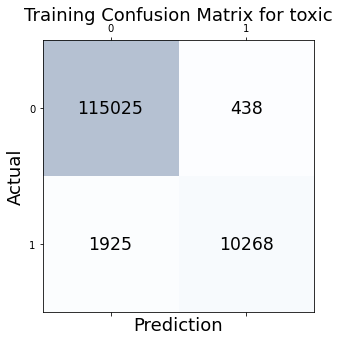

Testing Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     28814
           1       0.88      0.71      0.79      3101

    accuracy                           0.96     31915
   macro avg       0.93      0.85      0.88     31915
weighted avg       0.96      0.96      0.96     31915



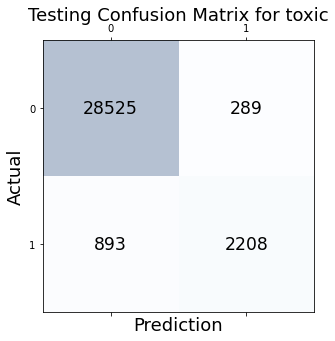

Training Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    126390
           1       0.89      0.68      0.77      1266

    accuracy                           1.00    127656
   macro avg       0.94      0.84      0.88    127656
weighted avg       1.00      1.00      1.00    127656



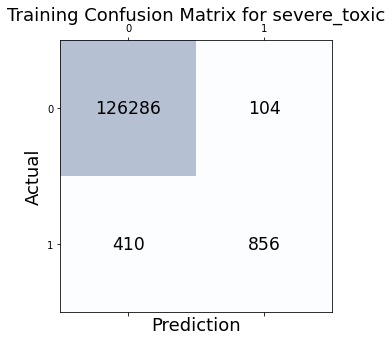

Testing Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     31586
           1       0.50      0.27      0.35       329

    accuracy                           0.99     31915
   macro avg       0.75      0.63      0.67     31915
weighted avg       0.99      0.99      0.99     31915



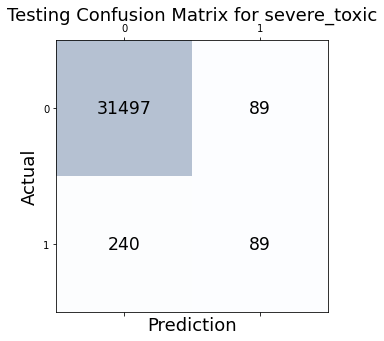

Training Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    120905
           1       0.96      0.88      0.92      6751

    accuracy                           0.99    127656
   macro avg       0.97      0.94      0.96    127656
weighted avg       0.99      0.99      0.99    127656



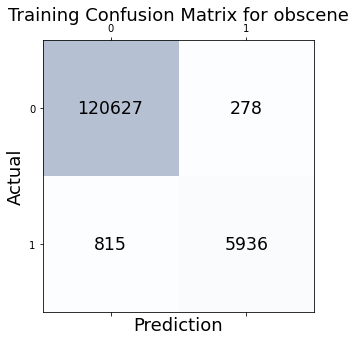

Testing Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     30217
           1       0.87      0.73      0.79      1698

    accuracy                           0.98     31915
   macro avg       0.93      0.86      0.89     31915
weighted avg       0.98      0.98      0.98     31915



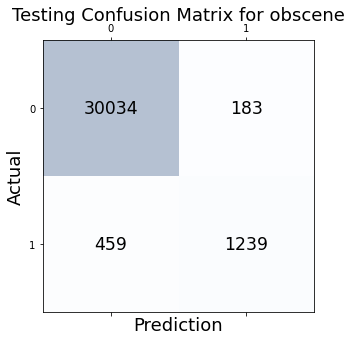

Training Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    127269
           1       0.97      0.80      0.88       387

    accuracy                           1.00    127656
   macro avg       0.99      0.90      0.94    127656
weighted avg       1.00      1.00      1.00    127656



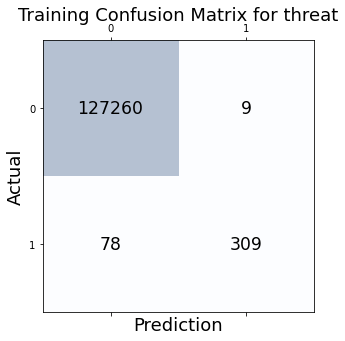

Testing Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31824
           1       0.74      0.29      0.41        91

    accuracy                           1.00     31915
   macro avg       0.87      0.64      0.71     31915
weighted avg       1.00      1.00      1.00     31915



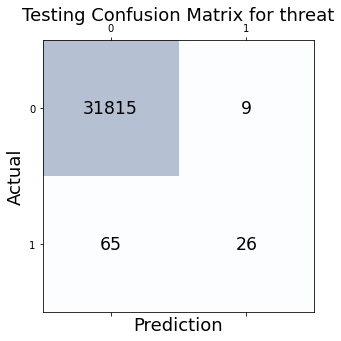

Training Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    121373
           1       0.92      0.81      0.86      6283

    accuracy                           0.99    127656
   macro avg       0.95      0.90      0.93    127656
weighted avg       0.99      0.99      0.99    127656



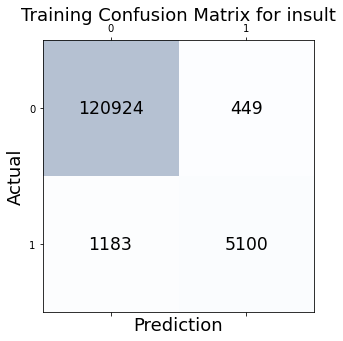

Testing Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     30321
           1       0.79      0.61      0.69      1594

    accuracy                           0.97     31915
   macro avg       0.89      0.80      0.84     31915
weighted avg       0.97      0.97      0.97     31915



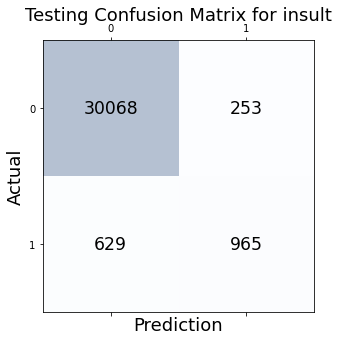

Training Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    126549
           1       0.95      0.67      0.78      1107

    accuracy                           1.00    127656
   macro avg       0.97      0.83      0.89    127656
weighted avg       1.00      1.00      1.00    127656



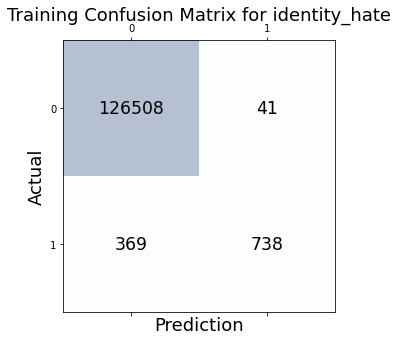

Testing Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     31617
           1       0.66      0.33      0.44       298

    accuracy                           0.99     31915
   macro avg       0.83      0.67      0.72     31915
weighted avg       0.99      0.99      0.99     31915



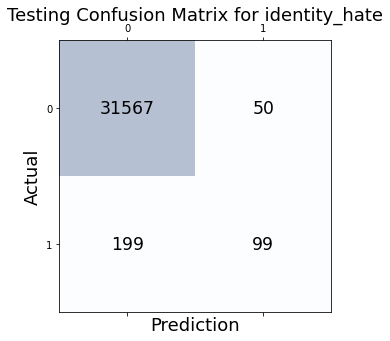

Training Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    114736
           1       0.97      0.85      0.90     12920

    accuracy                           0.98    127656
   macro avg       0.97      0.92      0.95    127656
weighted avg       0.98      0.98      0.98    127656



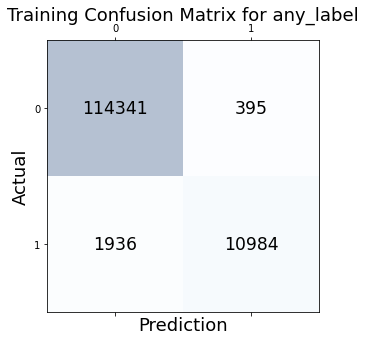

Testing Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     28610
           1       0.90      0.73      0.80      3305

    accuracy                           0.96     31915
   macro avg       0.93      0.86      0.89     31915
weighted avg       0.96      0.96      0.96     31915



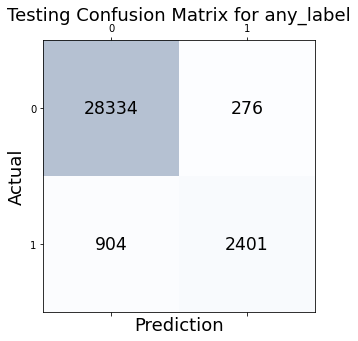

In [ ]:
model_evaluate(LinearSVC(C=0.5, random_state=0), X_train_validate, y_train_validate, X_test, y_test, 'svm')

In [ ]:
svm_cv_scores_opt = cross_validate(5, X, df_targets, LinearSVC(C=0.5, random_state=0))
svm_cv_scores_opt

{'toxic avg f1 score': 0.7861896836427268,
 'severe_toxic avg f1 score': 0.38603475905654294,
 'obscene avg f1 score': 0.7987703952263617,
 'threat avg f1 score': 0.4151086979855257,
 'insult avg f1 score': 0.6918480966084882,
 'identity_hate avg f1 score': 0.4184662988308638,
 'any_label avg f1 score': 0.8011148035160487}

In [ ]:
#Predict on Custom Input
test_string = 'this is a stupid article'
print(predict_custom(test_string, comment_vector, scaler, 'svm'))

{'toxic': [1], 'threat': [0], 'severe_toxic': [0], 'obscene': [1], 'insult': [1], 'identity_hate': [0], 'any_label': [1]}


In [ ]:
#Predict on Custom Input
test_string1 = "fuckin gays!!! You r a PUSSY!!"
test_string2 = "You should reconsider your suggestion. I don't think it will work like this."
print(predict_custom(test_string1, comment_vector, scaler, 'svm'))
print(predict_custom(test_string2, comment_vector, scaler, 'svm'))

{'toxic': [1], 'threat': [0], 'severe_toxic': [1], 'obscene': [1], 'insult': [1], 'identity_hate': [1], 'any_label': [1]}
{'toxic': [0], 'threat': [0], 'severe_toxic': [0], 'obscene': [0], 'insult': [0], 'identity_hate': [0], 'any_label': [0]}


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

#### Hyper Parameter Tuning

In [ ]:
#C=0.8
lrClassifier = LogisticRegression(C=0.8, random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], lrClassifier)
print(svc_cv_scores)

{'any_label avg f1 score': 0.7660755194071085}


In [ ]:
#C=0.5
lrClassifier = LogisticRegression(C=0.5, random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], lrClassifier)
print(svc_cv_scores)

{'any_label avg f1 score': 0.7503593677569528}


In [ ]:
#C=1.0
lrClassifier = LogisticRegression(C=1.0, random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], lrClassifier)
print(svc_cv_scores)

{'any_label avg f1 score': 0.7713593631108507}


In [ ]:
#C=1.2
lrClassifier = LogisticRegression(C=1.2, random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], lrClassifier)
print(svc_cv_scores)

{'any_label avg f1 score': 0.7763149999379589}


#### Model Evaluation

Training Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    115463
           1       0.94      0.73      0.82     12193

    accuracy                           0.97    127656
   macro avg       0.96      0.86      0.90    127656
weighted avg       0.97      0.97      0.97    127656



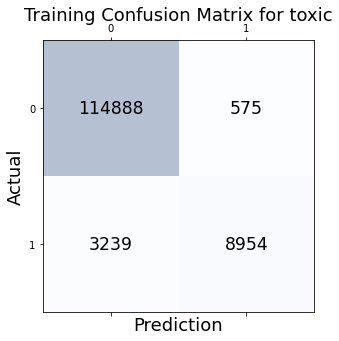

Testing Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     28814
           1       0.90      0.67      0.77      3101

    accuracy                           0.96     31915
   macro avg       0.93      0.83      0.87     31915
weighted avg       0.96      0.96      0.96     31915



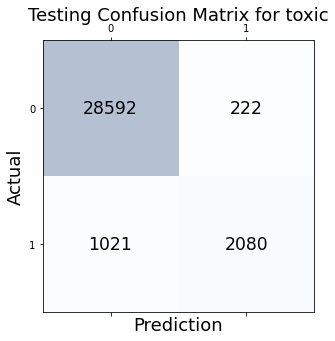

Training Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    126390
           1       0.71      0.40      0.51      1266

    accuracy                           0.99    127656
   macro avg       0.85      0.70      0.75    127656
weighted avg       0.99      0.99      0.99    127656



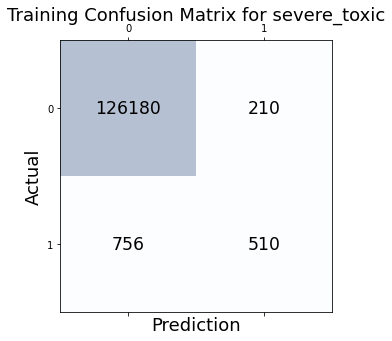

Testing Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     31586
           1       0.55      0.28      0.37       329

    accuracy                           0.99     31915
   macro avg       0.77      0.64      0.68     31915
weighted avg       0.99      0.99      0.99     31915



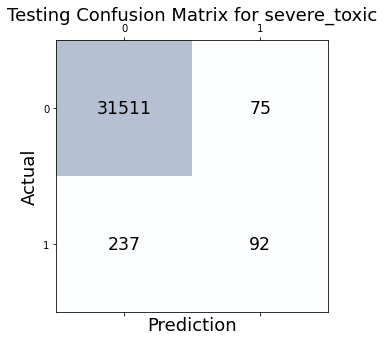

Training Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    120905
           1       0.93      0.76      0.84      6751

    accuracy                           0.98    127656
   macro avg       0.96      0.88      0.91    127656
weighted avg       0.98      0.98      0.98    127656



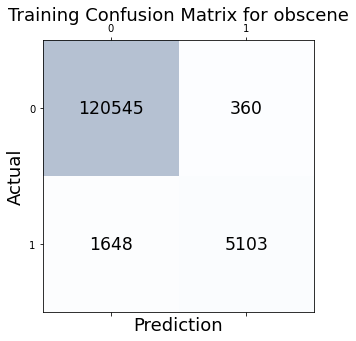

Testing Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     30217
           1       0.90      0.69      0.78      1698

    accuracy                           0.98     31915
   macro avg       0.94      0.84      0.88     31915
weighted avg       0.98      0.98      0.98     31915



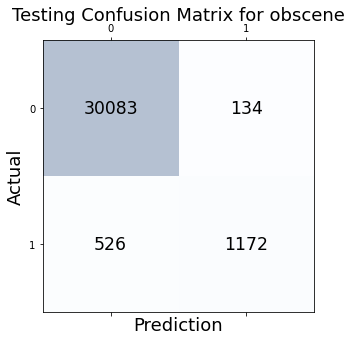

Training Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    127269
           1       0.84      0.31      0.45       387

    accuracy                           1.00    127656
   macro avg       0.92      0.65      0.72    127656
weighted avg       1.00      1.00      1.00    127656



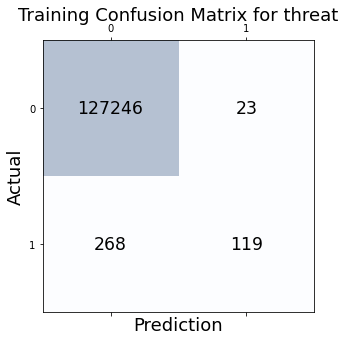

Testing Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31824
           1       0.72      0.25      0.37        91

    accuracy                           1.00     31915
   macro avg       0.86      0.63      0.69     31915
weighted avg       1.00      1.00      1.00     31915



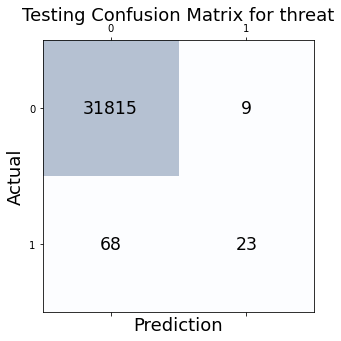

Training Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    121373
           1       0.87      0.66      0.75      6283

    accuracy                           0.98    127656
   macro avg       0.93      0.83      0.87    127656
weighted avg       0.98      0.98      0.98    127656



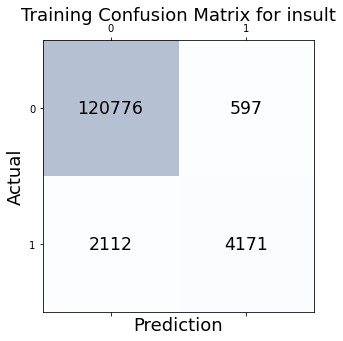

Testing Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     30321
           1       0.82      0.58      0.68      1594

    accuracy                           0.97     31915
   macro avg       0.90      0.79      0.83     31915
weighted avg       0.97      0.97      0.97     31915



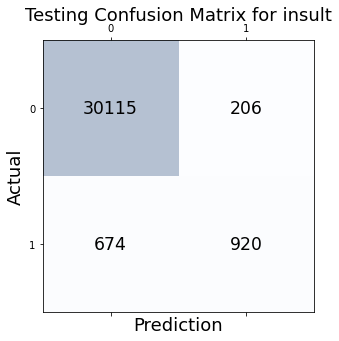

Training Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    126549
           1       0.85      0.35      0.49      1107

    accuracy                           0.99    127656
   macro avg       0.92      0.67      0.74    127656
weighted avg       0.99      0.99      0.99    127656



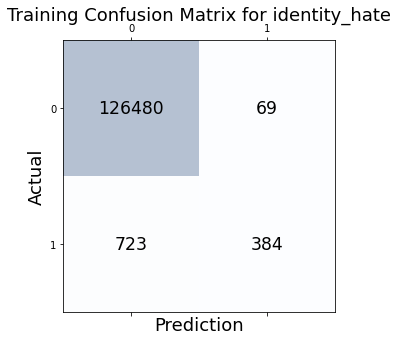

Testing Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     31617
           1       0.68      0.32      0.44       298

    accuracy                           0.99     31915
   macro avg       0.83      0.66      0.72     31915
weighted avg       0.99      0.99      0.99     31915



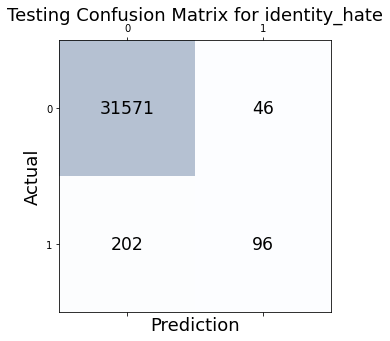

Training Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    114736
           1       0.95      0.74      0.83     12920

    accuracy                           0.97    127656
   macro avg       0.96      0.87      0.91    127656
weighted avg       0.97      0.97      0.97    127656



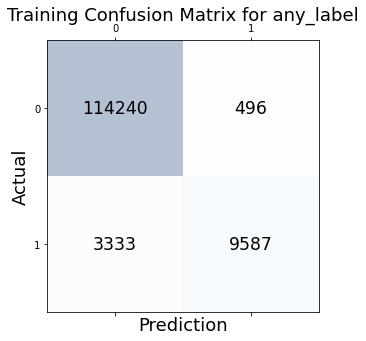

Testing Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     28610
           1       0.91      0.68      0.78      3305

    accuracy                           0.96     31915
   macro avg       0.94      0.83      0.88     31915
weighted avg       0.96      0.96      0.96     31915



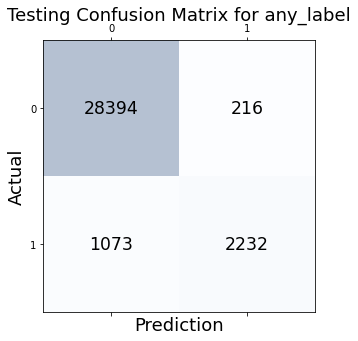

In [ ]:
model_evaluate(LogisticRegression(C=1.2, random_state=0), X_train_validate, y_train_validate, X_test, y_test, 'logisticReg')

In [ ]:
logReg_cv_scores_opt = cross_validate(5, X, df_targets, LogisticRegression(C=1.2, random_state=0))
logReg_cv_scores_opt

In [ ]:
#Predict on Custom Input
test_string = 'this is a stupid article'
print(predict_custom(test_string, comment_vector, scaler, 'logisticReg'))

{'toxic': [1], 'threat': [0], 'severe_toxic': [0], 'obscene': [1], 'insult': [1], 'identity_hate': [0], 'any_label': [1]}


### LightGBM Classifier

In [ ]:
import lightgbm as lgb

#### Hyper Parameter Tuning

In [ ]:
#C=0.8
dtClassifier = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=3, criterion='entropy', random_state=0)
svc_cv_scores = cross_validate(5, X_train_validate, y_train_validate[['any_label']], dtClassifier)
print(svc_cv_scores)